In [1]:
from mesmerize_core import *
import tifffile
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy
import pandas as pd

**You will need `fastplotlib` installed for the visualizations**

In [2]:
from fastplotlib import GridPlot, Image, Plot
from ipywidgets.widgets import IntSlider, VBox

In [3]:
pd.options.display.max_colwidth = 120

# Paths
These are the only variables you will need to modify in the demo notebook accoridng to your own `caiman_data` dir path

Explanation:

`set_parent_raw_data_path()` - This function from `mesmerize_core` sets the top level directory, it would generally be the top level directory for your raw experimental data. This allows you to move your experiment directory structure between computers, as long as you keep everything above the parent path the same.

For example,

On Linux based systems:

`/data/my_name/exp_top_level/....`

You could set `/data/my_name` as the parent raw data path, and you can then move `exp_top_level/...` between computers.

On windows:

`D:/my_name/exp_top_level/...`

You could set `D:/my_name` as the parent raw data path, and you can then move `exp_top_level/...` between computers.

In [4]:
# set the parent directory as the top-level directory for your experiment data
# this is always mandatory

# for this demo set this dir as the path to the `caiman_data` dir
set_parent_raw_data_path("/home/kushal/caiman_data/")

# this path can be anywhere, algorithm output files will be organized within here
batch_path = "/home/kushal/caiman_data/mesmerize-core-batch/batch.pickle"

# path to raw movie tiff file for the demo
# an input movies must be within `raw data path` or `batch path`
movie_path = "/home/kushal/caiman_data/example_movies/Sue_2x_3000_40_-46.tif"

In [5]:
# create a new batch
df = create_batch(batch_path)
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid


# Motion correction

In [6]:
# params, exactly the same as what you'd directly use with CaImAn
mcorr_params1 =\
{
  'main': # this key is necessary for specifying that these are the "main" params for the algorithm
    {
        'max_shifts': [24, 24],
        'strides': [48, 48],
        'overlaps': [24, 24],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# Add a "batch item", this is the combination of:
* algorithm to run, `algo`
* input movie to run the algorithm on, `input_movie_path`
* parameters for the specified algorithm, `params`
* a name for you to keep track of things, usually the same as the movie filename, `item_name`

In [7]:
# add an item to the batch
df.caiman.add_item(
  algo='mcorr',
  item_name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params1
)

df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,5d6219dd-da25-482f-971e-d4c420f2fe9d


## We can now see that there is one item in the batch dataframe, we can add another item with the same input movie but with different parameters

In [8]:
# We create another set of params, useful for gridsearches for example
mcorr_params2 =\
{
  'main':
    {
        'max_shifts': [24, 24],
        'strides': [24, 24],
        'overlaps': [12, 12],
        'max_deviation_rigid': 3,
        'border_nan': 'copy',
        'pw_rigid': True,
        'gSig_filt': None
    },
}

# add other param variant to the batch
df.caiman.add_item(
  algo='mcorr',
  item_name='my_movie',
  input_movie_path=movie_path,
  params=mcorr_params2
)

df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,5d6219dd-da25-482f-971e-d4c420f2fe9d
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,18d633e0-9db1-48ec-82e3-d0f377ffb2c9


## We can see that there are two batch items for the same input movie.

### We can also use a `for` loop to add multiple different parameter variants more efficiently. When adding batch items with the same `input_movie_path`, give them the same `item_name`.

In [9]:
# copy the mcorr_params2 dict to make some changes
new_params = deepcopy(mcorr_params2)

# some variants of max_shifts
for shifts in [6, 12, 32]: 
    # deep copy is the safest way to copy dicts
    new_params = deepcopy(new_params)
    
    # assign the "max_shifts"
    new_params["main"]["max_shifts"] = (shifts, shifts)
    
    df.caiman.add_item(
      algo='mcorr',
      item_name='my_movie',
      input_movie_path=movie_path,
      params=new_params
    )

In [10]:
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",None,None,5d6219dd-da25-482f-971e-d4c420f2fe9d
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,18d633e0-9db1-48ec-82e3-d0f377ffb2c9
2,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",None,None,c80e084f-9c09-488a-9e90-326960eef6cc
3,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (12, 12), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,6f928a28-f05c-4bd0-be6f-f195feac131b
4,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (32, 32), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",None,None,3842a003-75bb-456d-82db-b1efbc8b0ee5


### Now we can see that there are many parameter variants. We can use the `caiman.get_params_diffs()` extension to see the unique parameters for each

In [11]:
diffs = df.caiman.get_params_diffs(algo="mcorr", item_name="my_movie")
diffs

/tmp/ipykernel_1271314/3265976191.py:1: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_params_diffs


  diffs = df.caiman.get_params_diffs(algo="mcorr", item_name="my_movie")


0    {'overlaps': (24, 24), 'max_shifts': (24, 24), 'strides': (48, 48)}
1    {'overlaps': (12, 12), 'max_shifts': (24, 24), 'strides': (24, 24)}
2      {'overlaps': (12, 12), 'max_shifts': (6, 6), 'strides': (24, 24)}
3    {'overlaps': (12, 12), 'max_shifts': (12, 12), 'strides': (24, 24)}
4    {'overlaps': (12, 12), 'max_shifts': (32, 32), 'strides': (24, 24)}
Name: params, dtype: object

# Run batch item(s)
#### You can run a single batch item by calling `caiman.run()` on a `Series` (row) of the DataFrame. One way to get the row is integer indexing using `df.iloc[index]`

In [12]:
# run the first "batch item"
# this will run in a subprocess by default
process = df.iloc[0].caiman.run()
process.wait()

starting mc


100%|██████████| 1/1 [00:00<00:00,  3.28it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


0

### You can also use a `for` loop to run multiple batch items.

In [13]:
for i, row in df.iterrows():
    if not i > 0: # skip the first item since we've run it already
        continue
    process = row.caiman.run()
    process.wait() # this line is very important, otherwise you will simultaneously start all batch items!

starting mc


100%|██████████| 1/1 [00:00<00:00,  3.04it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
starting mc


100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
starting mc


100%|██████████| 1/1 [00:00<00:00,  2.38it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image
starting mc


100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


mc finished successfully!
computing projections
Computing correlation image
finished computing correlation image


## Reload the DataFrame to see the outputs information for the mcorr batch item
### It is necessary to ALWAYS use `load_batch()` after running a single batch item or a loop of batch items. You must not add new batch items until you re-load the batch after running any number of items!

In [14]:
df = load_batch(batch_path)
# we can see that the output for the first item is not empty
df

,algo,item_name,input_movie_path,params,outputs,comments,uuid
0,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (48, 48), 'overlaps': (24, 24), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d_mean_projection.n...,None,5d6219dd-da25-482f-971e-d4c420f2fe9d
1,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (24, 24), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 18d633e0-9db1-48ec-82e3-d0f377ffb2c9/18d633e0-9db1-48ec-82e3-d0f377ffb2c9_mean_projection.n...,None,18d633e0-9db1-48ec-82e3-d0f377ffb2c9
2,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (6, 6), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan': '...",{'mean-projection-path': c80e084f-9c09-488a-9e90-326960eef6cc/c80e084f-9c09-488a-9e90-326960eef6cc_mean_projection.n...,None,c80e084f-9c09-488a-9e90-326960eef6cc
3,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (12, 12), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 6f928a28-f05c-4bd0-be6f-f195feac131b/6f928a28-f05c-4bd0-be6f-f195feac131b_mean_projection.n...,None,6f928a28-f05c-4bd0-be6f-f195feac131b
4,mcorr,my_movie,example_movies/Sue_2x_3000_40_-46.tif,"{'main': {'max_shifts': (32, 32), 'strides': (24, 24), 'overlaps': (12, 12), 'max_deviation_rigid': 3, 'border_nan':...",{'mean-projection-path': 3842a003-75bb-456d-82db-b1efbc8b0ee5/3842a003-75bb-456d-82db-b1efbc8b0ee5_mean_projection.n...,None,3842a003-75bb-456d-82db-b1efbc8b0ee5


# Check if the algorithm ran successfully 

In [15]:
# True if the algo ran succesfully
df.iloc[0]["outputs"]["success"]

True

Path to the output memmap file, you usually don't need to use this manually, just FYI

In [16]:
# use extensions to get the full path the outputs and other useful things
# you should always use the extensions
# never handle the "outputs" dict manually!
df.iloc[0].mcorr.get_output_path()

PosixPath('/home/kushal/caiman_data/mesmerize-core-batch/5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1_order_F_frames_3000_.mmap')

In [17]:
# similarly resolve the full input movie path
df.iloc[0].caiman.get_input_movie_path()

PosixPath('/home/kushal/caiman_data/example_movies/Sue_2x_3000_40_-46.tif')

# Visualization using `fastplotlib`
You will need `fastplotlib` installed for this, see https://github.com/kushalkolar/fastplotlib

Get the input movie and mcorr so we can visualize them

In [18]:
# you can change the index to look at the mcorr results of different batch items
index = 0

# Load the input and output movies so we can view them
input_movie = tifffile.imread(df.iloc[index].caiman.get_input_movie_path())

# extension for loading the mcorr movie
mcorr_movie = df.iloc[index].mcorr.get_output()

# Raw & MCorr movie side-by-side
This cell just plots the raw & mcorr movie side by side and uses a slider for updating the frame index for random-access scrolling

In [19]:
# gridplot with 1 row, 2 columns
gp = GridPlot(
    shape=(1, 2),
    controllers="sync" # this is to that we can pan-zoom in sync
)

input_graphic = Image(
    data=input_movie[0], # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

mcorr_graphic = Image(
    data=mcorr_movie[0], # image data for the first frame
    cmap='gnuplot2'
)

# add the grahpics to the subplots
gp.subplots[0, 0].add_graphic(input_graphic)
gp.subplots[0, 1].add_graphic(mcorr_graphic)

# make a GUI slider
slider = IntSlider(value=0, min=0, max=input_movie.shape[0] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_frame():
    global previous_value
    if previous_value == slider.value:
        return
    
    input_graphic.update_data(input_movie[slider.value])
    mcorr_graphic.update_data(mcorr_movie[slider.value])
    
# add to the animation so that this is run in every render cycle
gp.add_animations([update_frame])

# show the gridplot and slider
VBox([gp.show(), slider])

RFBOutputContext()

**Close the canvas if your don't have a powerful GPU so that you can plot more visualizations later.**

In [20]:
gp.canvas.close()

# CNMF

## Continue from mcorr above and perform CNMF using the mcorr output

In [21]:
# some params for CNMF
params_cnmf =\
{
    'main': # indicates that these are the "main" params for the CNMF algo
        {
            'fr': 30, # framerate, very important!
            'p': 1,
            'nb': 2,
            'merge_thr': 0.85,
            'rf': 15,
            'stride': 6, # "stride" for cnmf, "strides" for mcorr
            'K': 4,
            'gSig': [4, 4],
            'ssub': 1,
            'tsub': 1,
            'method_init': 'greedy_roi',
            'min_SNR': 2.0,
            'rval_thr': 0.7,
            'use_cnn': True,
            'min_cnn_thr': 0.8,
            'cnn_lowest': 0.1,
            'decay_time': 0.4,
        },
    'refit': True, # If `True`, run a second iteration of CNMF
}

### Add a single cnmf item to the batch

In [22]:
# add a batch item
df.caiman.add_item(
  algo='cnmf', # algo is cnmf
  item_name='my_movie',
  input_movie_path=df.iloc[0].mcorr.get_output_path(),  # use mcorr output from a completed batch item
  params=params_cnmf
)

### Just like with motion correction, we can use `for` loops to add multiple parameter variants. This is useful to perform a parameter search to find the params that work best for your dataset. Here I will use `itertools.product` which is better than deeply nested loops.

In [23]:
from itertools import product

gSig_variants = [6, 8]
K_variants = [4, 8]
merge_thr_variants = [0.8, 0.95]

# always use deepcopy like before
new_params_cnmf = deepcopy(params_cnmf)

for gSig, K, merge_thr in product(gSig_variants, K_variants, merge_thr_variants):
    # deep copy at every level of the loop
    new_params_cnmf = deepcopy(new_params_cnmf)
    
    new_params_cnmf["main"]["gSig"] = [gSig, gSig]
    new_params_cnmf["main"]["K"] = K
    new_params_cnmf["main"]["merge_thr"] = merge_thr
    
    # add param combination variant to batch
    df.caiman.add_item(
        algo="cnmf",
        item_name="my_movie",
        input_movie_path=df.iloc[0].mcorr.get_output_path(),
        params=new_params_cnmf
    )

### See that there are a lot of new cnmf batch items

In [24]:
df[df["algo"] == "cnmf"]

,algo,item_name,input_movie_path,params,outputs,comments,uuid
5,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 't...",None,None,766b7274-dd67-4b5c-b8af-240d04e2ea49
6,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'ts...",None,None,e2a08060-a84d-41d8-bbfb-e884af663093
7,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,c0589d31-9728-44f0-806a-7ff34b12a8c0
8,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'ts...",None,None,400f6cde-4ad8-459f-a43a-9abaf75dc081
9,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 't...",None,None,95ed4cef-548d-4959-b665-793532af9cb8
10,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,42b8b7e5-23c4-4bf7-8def-529efcb08134
11,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,5df9df38-775a-4828-a8d7-ff3de3874104
12,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'ts...",None,None,0eeb63e4-1634-4d19-915c-2faf556f872f
13,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 't...",None,None,de998014-8722-4e3f-84be-bf148a23e43e


## Since it is difficult to see the different parameter variants above, we can just view the diffs

### The index numbers on the diffs correspond to the indices in the parent DataFrame above

In [25]:
df.caiman.get_params_diffs(algo="cnmf", item_name="my_movie")

/tmp/ipykernel_1271314/777897395.py:1: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanDataFrameExtensions.get_params_diffs


  df.caiman.get_params_diffs(algo="cnmf", item_name="my_movie")


5     {'K': 4, 'gSig': (4, 4), 'merge_thr': 0.85}
6      {'K': 4, 'gSig': (6, 6), 'merge_thr': 0.8}
7     {'K': 4, 'gSig': (6, 6), 'merge_thr': 0.95}
8      {'K': 8, 'gSig': (6, 6), 'merge_thr': 0.8}
9     {'K': 8, 'gSig': (6, 6), 'merge_thr': 0.95}
10     {'K': 4, 'gSig': (8, 8), 'merge_thr': 0.8}
11    {'K': 4, 'gSig': (8, 8), 'merge_thr': 0.95}
12     {'K': 8, 'gSig': (8, 8), 'merge_thr': 0.8}
13    {'K': 8, 'gSig': (8, 8), 'merge_thr': 0.95}
Name: params, dtype: object

### Run the added `cnmf` batch items, they start at index 5 as we can see from the DataFrame

In [26]:
for i, row in df.iterrows():
    if i < 5:
        continue
    process = df.iloc[i].caiman.run()
    process.wait()

cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
making memmap


2022-09-20 23:52:16.767776: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:52:16.767798: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:52:16.767802: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:52:16.767888: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:52:16.767899: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:52:16.767902: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:52:16.770681: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
5/5 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
making memmap


2022-09-20 23:52:40.401221: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:52:40.401253: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:52:40.401257: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:52:40.401507: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:52:40.401520: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:52:40.401524: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:52:40.406153: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
making memmap


2022-09-20 23:53:03.543384: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:53:03.543413: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:53:03.543417: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:53:03.543670: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:53:03.544142: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:53:03.544147: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:53:03.548019: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
making memmap


2022-09-20 23:53:29.924692: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:53:29.924756: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:53:29.924764: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:53:29.924885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:53:29.925351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:53:29.925360: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:53:29.931365: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
11/11 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}
making memmap


2022-09-20 23:53:57.128291: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:53:57.128351: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:53:57.128358: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:53:57.128467: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:53:57.129154: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:53:57.129159: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:53:57.135734: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
12/12 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


making memmap


2022-09-20 23:54:22.110207: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:54:22.110262: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:54:22.110266: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:54:22.110379: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:54:22.110393: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:54:22.110397: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:54:22.113206: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


making memmap


2022-09-20 23:54:47.045533: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:54:47.045716: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:54:47.045725: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:54:47.046063: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:54:47.046561: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:54:47.046568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:54:47.051162: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
6/6 [==============================] - 0s 6ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


making memmap


2022-09-20 23:55:15.899573: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:55:15.899616: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:55:15.899620: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:55:15.899753: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:55:15.900207: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:55:15.900213: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:55:15.904884: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
11/11 [==============================] - 0s 7ms/step
cnmf params {'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'tsub': 1, 'method_init': 'greedy_roi', 'min_SNR': 2.0, 'rval_thr': 0.7, 'use_cnn': True, 'min_cnn_thr': 0.8, 'cnn_lowest': 0.1, 'decay_time': 0.4}, 'refit': True}


making memmap


2022-09-20 23:55:44.588392: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-09-20 23:55:44.588461: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: kushal-desktop
2022-09-20 23:55:44.588468: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: kushal-desktop
2022-09-20 23:55:44.588589: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 515.48.7
2022-09-20 23:55:44.589061: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 515.48.7
2022-09-20 23:55:44.589067: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 515.48.7
2022-09-20 23:55:44.594868: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance

performing CNMF
fitting images
refitting
Eval
USING MODEL:/home/kushal/caiman_data/model/cnn_model.json
12/12 [==============================] - 0s 7ms/step


### Look at the CNMF outputs

In [27]:
df = load_batch(batch_path)
df[df["algo"] == "cnmf"]

,algo,item_name,input_movie_path,params,outputs,comments,uuid
5,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.85, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (4, 4), 'ssub': 1, 't...",{'mean-projection-path': 766b7274-dd67-4b5c-b8af-240d04e2ea49/766b7274-dd67-4b5c-b8af-240d04e2ea49_mean_projection.n...,None,766b7274-dd67-4b5c-b8af-240d04e2ea49
6,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 'ts...",{'mean-projection-path': e2a08060-a84d-41d8-bbfb-e884af663093/e2a08060-a84d-41d8-bbfb-e884af663093_mean_projection.n...,None,e2a08060-a84d-41d8-bbfb-e884af663093
7,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (6, 6), 'ssub': 1, 't...",{'mean-projection-path': c0589d31-9728-44f0-806a-7ff34b12a8c0/c0589d31-9728-44f0-806a-7ff34b12a8c0_mean_projection.n...,None,c0589d31-9728-44f0-806a-7ff34b12a8c0
8,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 'ts...",{'mean-projection-path': 400f6cde-4ad8-459f-a43a-9abaf75dc081/400f6cde-4ad8-459f-a43a-9abaf75dc081_mean_projection.n...,None,400f6cde-4ad8-459f-a43a-9abaf75dc081
9,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (6, 6), 'ssub': 1, 't...",{'mean-projection-path': 95ed4cef-548d-4959-b665-793532af9cb8/95ed4cef-548d-4959-b665-793532af9cb8_mean_projection.n...,None,95ed4cef-548d-4959-b665-793532af9cb8
10,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 'ts...",{'mean-projection-path': 42b8b7e5-23c4-4bf7-8def-529efcb08134/42b8b7e5-23c4-4bf7-8def-529efcb08134_mean_projection.n...,None,42b8b7e5-23c4-4bf7-8def-529efcb08134
11,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 4, 'gSig': (8, 8), 'ssub': 1, 't...",{'mean-projection-path': 5df9df38-775a-4828-a8d7-ff3de3874104/5df9df38-775a-4828-a8d7-ff3de3874104_mean_projection.n...,None,5df9df38-775a-4828-a8d7-ff3de3874104
12,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.8, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 'ts...",{'mean-projection-path': 0eeb63e4-1634-4d19-915c-2faf556f872f/0eeb63e4-1634-4d19-915c-2faf556f872f_mean_projection.n...,None,0eeb63e4-1634-4d19-915c-2faf556f872f
13,cnmf,my_movie,5d6219dd-da25-482f-971e-d4c420f2fe9d/5d6219dd-da25-482f-971e-d4c420f2fe9d-Sue_2x_3000_40_-46_els__d1_170_d2_170_d3_1...,"{'main': {'fr': 30, 'p': 1, 'nb': 2, 'merge_thr': 0.95, 'rf': 15, 'stride': 6, 'K': 8, 'gSig': (8, 8), 'ssub': 1, 't...",{'mean-projection-path': de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_mean_projection.n...,None,de998014-8722-4e3f-84be-bf148a23e43e


### Look at a single output. Note: you SHOULD NOT access these outputs dicts manually! Use the cnmf extensions to use the cnmf output. This is just FYI

In [28]:
df.iloc[-1]["outputs"]

{'mean-projection-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_mean_projection.npy'),
 'std-projection-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_std_projection.npy'),
 'max-projection-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_max_projection.npy'),
 'cnmf-hdf5-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e.hdf5'),
 'cnmf-memmap-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_cnmf-memmap__d1_170_d2_170_d3_1_order_C_frames_3000_.mmap'),
 'corr-img-path': PosixPath('de998014-8722-4e3f-84be-bf148a23e43e/de998014-8722-4e3f-84be-bf148a23e43e_cn.npy'),
 'success': True,
 'traceback': None}

In [29]:
# see which batch items completed succcessfully
df[df["algo"] == "cnmf"]["outputs"].apply(lambda x: x["success"])

5     True
6     True
7     True
8     True
9     True
10    True
11    True
12    True
13    True
Name: outputs, dtype: bool

# Load outputs
For visualization

In [31]:
# You can change this to plot the outputs for different batch items
index = 5

# get the motion corrected movie as a memmap
cnmf_movie = df.iloc[index].caiman.get_input_movie()

# we can get the contours of the spatial components
coors, coms = df.iloc[index].cnmf.get_contours(component_indices="good")

# get bad components
coors_bad, coms_bad = df.iloc[index].cnmf.get_contours(component_indices="bad")

/tmp/ipykernel_1271314/2535920265.py:5: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanSeriesExtensions.get_input_movie


  cnmf_movie = df.iloc[index].caiman.get_input_movie()


# Plot contours for good components on the motion corrected movie

In [32]:
# create a simple plot
plot = Plot()

# plot the first frame, transpose so it lines up with contours
image_graphic = plot.image(data=cnmf_movie[0].T, cmap='gray')

# plot all the good contours in cyan
for coor in coors:
    # just [R, G, B, A] -> red, green, blue, alpha (transparency)
    colors = [0, 1, 1, 0.7]
    plot.line(data=coor, zlevel=1, colors=colors)

# plot all bad good contours in magenta
for coor in coors_bad:
    colors = [1, 0, 1, 0.7]
    plot.line(data=coor, zlevel=1, colors=colors)
    
# make a slider like for mcorr
slider_cnmf = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1)
    
previous_ix = 0

# animate func just like mcorr viz
def update_frame_cnmf():
    if slider_cnmf.value == previous_ix:
        return
    # update with frame from slider value, again transpose to line up with contours
    image_graphic.update_data(data=cnmf_movie[slider_cnmf.value].T)

plot.add_animations([update_frame_cnmf])
    
VBox([plot.show(), slider_cnmf])

RFBOutputContext()

In [33]:
plot.canvas.close()

# View the reconstructed movie, residuals, and reconstructed background

In [34]:
# gridplot with 1 row, 2 columns
gp_rcm = GridPlot(
    shape=(2, 2),
    controllers="sync"
)

# for the mcorr movie
left_graphic = Image(
    data=cnmf_movie[0].T, # image data for the first frame
    cmap='gnuplot2' # my favorite colormap
)

# get the first frame of reconstructed movie
rcm0 = df.iloc[index].cnmf.get_rcm(component_indices="good", frame_indices=0)[0]

# create the graphic
right_graphic = Image(
    data=rcm0.T, # image data for the first frame
    vmin=0,
    vmax=100,
    cmap='gnuplot2'
)

# residuals
resid0 = df.iloc[index].cnmf.get_residuals(frame_indices=0)[0]
resid_graphic = Image(
    data=resid0,
    cmap="gnuplot2",
)

# reconstructed background, b * f
recon_bg0 = df.iloc[index].cnmf.get_rcb(frame_indices=0)[0]
recon_bg_graphic = Image(
    data=recon_bg0,
    cmap="gnuplot2",
)


# add the grahpics to the subplots
gp_rcm.subplots[0, 0].add_graphic(left_graphic)
gp_rcm.subplots[0, 1].add_graphic(right_graphic)
gp_rcm.subplots[1, 0].add_graphic(resid_graphic)
gp_rcm.subplots[1, 1].add_graphic(recon_bg_graphic)

# make a GUI slider
slider_rcm = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1)

previous_value = 0

# a function to update the frame based on the slider value
def update_rcm_frame():
    global previous_value
    if previous_value == slider_rcm.value:
        return
    
    left_graphic.update_data(cnmf_movie[slider_rcm.value].T)
        
    # get the A x C for just 1 frame
    rcm_frame = df.iloc[index].cnmf.get_rcm(component_indices="good", frame_indices=slider_rcm.value)[0]
    right_graphic.update_data(rcm_frame.T)
    
    # residuals for 1 frame
    resid_frame = df.iloc[index].cnmf.get_residuals(frame_indices=slider_rcm.value)[0]
    resid_graphic.update_data(resid_frame)
    
    # b * f for 1 frame
    recon_bg_frame = df.iloc[index].cnmf.get_rcb(frame_indices=slider_rcm.value)[0]
    recon_bg_graphic.update_data(recon_bg_frame)
    
    previous_value = slider_rcm.value
    
# add to the animation so that this is run in every render cycle
gp_rcm.add_animations([update_rcm_frame])
VBox([gp_rcm.show(), slider_rcm])

RFBOutputContext()

### Close the canvas to free up the GPU

In [35]:
gp_rcm.canvas.close()

### You can get the temporal components using `cnmf.get_temporal()`. Visualize using `seaborn`, stacked line plots and heatmaps are not yet implemented in `fastplotlib`.

<AxesSubplot:>

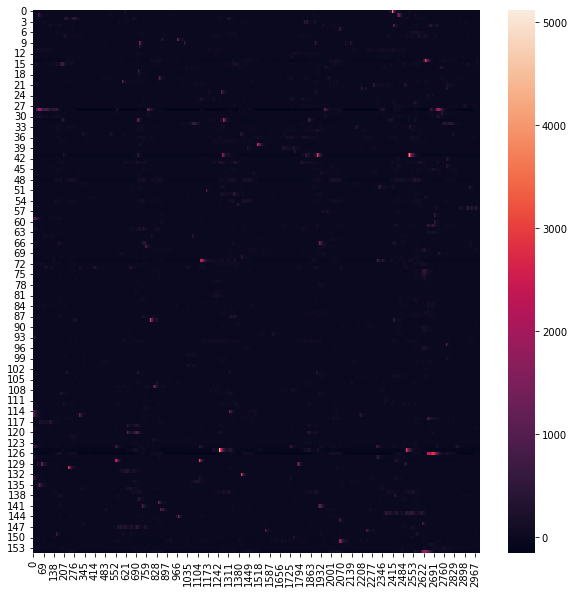

In [36]:
import seaborn as sns # if you have seaborn installed

fig = plt.figure(figsize=(10, 10))
sns.heatmap(df.iloc[index].cnmf.get_temporal())

# Component Evaluation

These are some ipywidgets that you can use for interactive component evaluation

In [37]:
# import some stuff
from ipywidgets import FloatSlider, FloatText, Label, HBox, VBox, link, Layout
from collections import OrderedDict

#### This is just GUI layout stuff

In [38]:
# low thresholds
lt = OrderedDict(
    rval_lowest=(-1.0, -1.0, 1.0), # (val, min, max)
    SNR_lowest=(0.5, 0., 100), 
    cnn_lowest=(0.1, 0., 1.0),
)

# high thresholds
ht = OrderedDict(
    rval_thr=(0.8, 0., 1.0),
    min_SNR=(2.5, 0., 100),
    min_cnn_thr=(0.9, 0., 1.0),
)

lw = list()
for k in lt:
    kwargs = dict(value=lt[k][0], min=lt[k][1], max=lt[k][2], step=0.01, description=k)
    slider = FloatSlider(**kwargs)
    entry = FloatText(**kwargs, layout=Layout(width="150px"))
    
    link((slider, "value"), (entry, "value"))
    
    lw.append(HBox([slider, entry]))
    
hw = list()
for k in ht:
    kwargs = dict(value=ht[k][0], min=ht[k][1], max=ht[k][2], step=0.01, description=k)
    slider = FloatSlider(**kwargs)
    entry = FloatText(**kwargs, layout=Layout(width="150px"))
    
    link((slider, "value"), (entry, "value"))
    
    hw.append(HBox([slider, entry]))

def get_eval_params():
    """get the values from the GUI"""
    _eval_params = [{w.children[0].description: w.children[0].value for w in ws} for ws in [lw, hw]]
    return {**_eval_params[0], **_eval_params[1]}

### Get the contour coordinates and cnmf movie for the 5th index

In [39]:
# You can change this index to do eval for different batch items
index = 5

# get the motion corrected movie as a memmap
cnmf_movie = df.iloc[index].caiman.get_input_movie()

# we can get the contours of the spatial components
coors_all, coms_all = df.iloc[index].cnmf.get_contours(component_indices="all")

# initial good and bad component indices
good_ixs = df.iloc[index].cnmf.get_good_components()
bad_ixs = df.iloc[index].cnmf.get_bad_components()

# RGBA array, good = cyan, bad = magenta
good_color = [0, 1, 1, 0.7]
bad_color = [1, 0, 1, 0.7]

/tmp/ipykernel_1271314/3614576863.py:5: FutureWarning: You are trying to use the following experimental feature, this may change in the future without warning:
CaimanSeriesExtensions.get_input_movie


  cnmf_movie = df.iloc[index].caiman.get_input_movie()


#### Sanity check

In [40]:
len(coors_all) == good_ixs.size + bad_ixs.size

True

### This plot updates the contour colors interactively to label them as bad or good. It also stores them in the batch item's params dict in a new key called `"eval"`, you can view them using `df.iloc[index].params`.

In [41]:
eval_params = get_eval_params()

# create a simple plot
plot = Plot()

# plot the first frame, transpose so it lines up with contours
image_graphic = plot.image(data=cnmf_movie[0].T, cmap='gray')

# plot contours according to good/bad colors
contour_graphics = list()
for ix, coor in enumerate(coors_all):
    if ix in good_ixs:
        color = good_color
    elif ix in bad_ixs:
        color = bad_color
    cg = plot.line(data=coor, zlevel=1, colors=color)
    contour_graphics.append(cg)
    
# make a slider like for mcorr
slider_cnmf = IntSlider(value=0, min=0, max=cnmf_movie.shape[0] - 1, step=1, description="frame index")
    
previous_ix = 0

label_eval = Label(value="")

# animate func just like mcorr viz
def update_frame_cnmf():
    global eval_params
    global previous_ix
    if slider_cnmf.value != previous_ix:
        # update with frame from slider value, again transpose to line up with contours
        image_graphic.update_data(data=cnmf_movie[slider_cnmf.value].T)
        previous_ix = slider_cnmf.value
    
    new_eval_params = get_eval_params()
    if new_eval_params == eval_params:
        return
    label_eval.value = "Please wait running eval..."
    # run eval
    df.iloc[index].cnmf.run_eval(new_eval_params)
    
    # get the new indices after eval
    good_ixs = df.iloc[index].cnmf.get_good_components()
    bad_ixs = df.iloc[index].cnmf.get_bad_components()

    for ix, cg in enumerate(contour_graphics):
        if ix in good_ixs:
            color = good_color
        elif ix in bad_ixs:
            color = bad_color
        cg.update_colors(color)
    label_eval.value= "Eval done!"
    eval_params = new_eval_params

plot.add_animations([update_frame_cnmf])
    
VBox([
    plot.show(), 
    slider_cnmf,
    label_eval,
    Label(value="Low Thresholds"),
    *lw,
    Label(value="High Thresholds"),
    *hw   
])

RFBOutputContext()

### Eval params are stored, you can view them here:

In [43]:
df.iloc[index].params

{'main': {'fr': 30,
  'p': 1,
  'nb': 2,
  'merge_thr': 0.85,
  'rf': 15,
  'stride': 6,
  'K': 4,
  'gSig': (4, 4),
  'ssub': 1,
  'tsub': 1,
  'method_init': 'greedy_roi',
  'min_SNR': 2.0,
  'rval_thr': 0.7,
  'use_cnn': True,
  'min_cnn_thr': 0.8,
  'cnn_lowest': 0.1,
  'decay_time': 0.4},
 'refit': True,
 'eval': {'rval_lowest': -1.0,
  'SNR_lowest': 1.82,
  'cnn_lowest': 0.24,
  'rval_thr': 0.4,
  'min_SNR': 0.0,
  'min_cnn_thr': 0.11}}

### If you want to save them to disk use the `caiman.save_to_disk()` extension. Changes to the DataFrame are only saved when you use `caiman.add_item()`. In other cases, such as saving the eval params, you can use `save_to_disk()`

In [44]:
df.caiman.save_to_disk()